<a href="https://colab.research.google.com/github/juanalvarez96/KAGGLE_DATASCIENCE/blob/master/Kaggle_winners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Libraries
%matplotlib inline
#PyTorch, of course
import torch
import torch.nn as nn

#We will need torchvision transforms for data augmentation
from torchvision import transforms
import torchvision
### utilities
# tool to print a nice summary of a network, similary to keras' summary
from torchsummary import summary

# library to do bash-like wildcard expansion
import glob
import matplotlib.pyplot as plt

# others
import numpy as np
import random
from PIL import Image
from IPython.display import display
from tqdm import tqdm_notebook
from torchvision import datasets
from google.colab import drive
drive.mount('/content/drive')

train_path = "/content/drive/My Drive/polytech-ds-2019/polytech-ds-2019/training"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# **Import Data and generate DataLoaders**
This process will be carried out using tbe torchvisison datasets set of function for importing data.\
Since the provided data is shuffled, we will organize each picture in folders. This implies, for every image from the training and validation folders, we will move it to a class folder.


1.   Create for the validation folder 10 folders following the structure: class0, class1, ..., class10
2.   Move every image from validation folder to its respective class folder. Move 01_xyz.jpg to class1, move 02_xyz.jpg to class2, ...
3. Repeat these two steps fro the training floder



In [0]:
transformations=transforms.Compose([
        transforms.RandomResizedCrop(250),
        transforms.RandomHorizontalFlip(),
        #transforms.Resize(250),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [0]:
# Needed to organize data for the classifier.
# Only do ONE TIME for the training
% cd /content/drive/My\ Drive/polytech-ds-2019/polytech-ds-2019/training
#! for i in `seq 0 10`; do mkdir class${i}; done
#! for i in `seq 0 10`; do mv ${i}_* class$i; done
! for i in `seq 0 10`; do ls -lh class${i}/ | wc -l; done

/content/drive/My Drive/polytech-ds-2019/polytech-ds-2019/training
995
430
1501
987
849
1326
441
281
856
1501
710


In [0]:
# Needed to organize data for the classifier.
# Only do ONE TIME for the validation
#! for i in `seq 0 10`; do mkdir ../validation/class${i}; done
#! for i in `seq 0 10`; do mv ../validation/${i}_* ../validation/class$i; done
! for i in `seq 0 10`; do ls -lh ../validation/class${i}/ | wc -l; done

365
145
502
329
327
451
148
100
348
504
233


In [0]:
# Load in each dataset and apply transformations using
# the torchvision.datasets as datasets library
% cd /content/drive/My\ Drive/polytech-ds-2019/polytech-ds-2019/training
data_set = datasets.ImageFolder(root="./", transform = transformations)
val_set = datasets.ImageFolder(root="../validation/", transform = transformations)

/content/drive/My Drive/polytech-ds-2019/polytech-ds-2019/training


In [0]:
# Split data
test_split = 0.3
N_test_samples = round(test_split * len(data_set))
train_set, test_set = torch.utils.data.random_split(data_set, [len(data_set) - N_test_samples, N_test_samples])


In [0]:
# Put data into a DataLoader
data_loader = torch.utils.data.DataLoader(data_set, batch_size=32, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)

In [0]:
tensor, labels = next(iter(test_loader))
tensor.size()

torch.Size([32, 3, 250, 250])

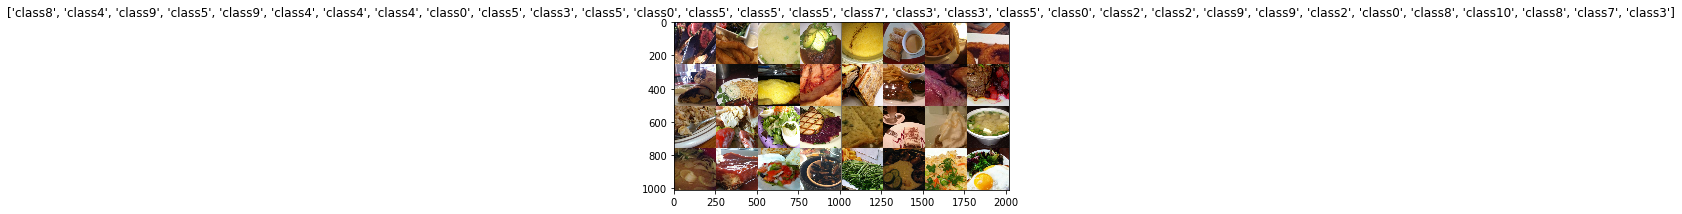

In [0]:
# Visualize image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(data_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
class_names = data_set.classes
imshow(out, title=[class_names[x] for x in classes])


In [0]:
class CompactUNet(nn.Module):
  
  def __init__(self):
    super(CompactUNet, self).__init__()
    
    ## Encoder
    
    self.conv1_1 = nn.Conv2d(3, 8, 3, padding=1)
    self.conv1_2 = nn.Conv2d(8, 8, 3, padding=1)
    
    self.conv2_1 = nn.Conv2d(8, 16, 3, padding=1)
    self.conv2_2 = nn.Conv2d(16, 16, 3, padding=1)
    
    self.conv3_1 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3_2 = nn.Conv2d(32, 32, 3, padding=1)
    
    ## Decoder
    
    self.up_conv1 = nn.ConvTranspose2d(32, 16, 2, stride=2, output_padding=1)
    
    self.conv4_1 = nn.Conv2d(32, 16, 3, padding=1)
    self.conv4_2 = nn.Conv2d(16, 16, 3, padding=1)
    
    self.up_conv2 = nn.ConvTranspose2d(16, 8, 2, stride=2)
    
    self.conv5_1 = nn.Conv2d(16, 8, 3, padding=1)
    self.conv5_2 = nn.Conv2d(8, 8, 3, padding=1)
    
    self.conv1x1 = nn.Conv2d(8, 1, 1)
    
    ## Other layers
    
    self.relu = nn.ReLU()
    
    self.maxpool = nn.MaxPool2d(2)
    
  def forward(self, x):
    
    ##Encoder
    
    #Stage 1
    x = self.conv1_1(x)
    x = self.relu(x)
    
    x = self.conv1_2(x)
    x = self.relu(x)
    
    skip1 = x
    
    #Stage 2
    x = self.maxpool(x)
    
    x = self.conv2_1(x)
    x = self.relu(x)
    
    x = self.conv2_2(x)
    x = self.relu(x)
    
    skip2 = x
    
    #Stage 3
    x = self.maxpool(x)
    
    x = self.conv3_1(x)
    x = self.relu(x)
    
    x = self.conv3_2(x)
    x = self.relu(x)
    
    ##Decoder
    
    #Stage 4
    x = self.up_conv1(x)
    
    x = torch.cat((skip2,x),1)
    
    x = self.conv4_1(x)
    x = self.relu(x)
    
    x = self.conv4_2(x)
    x = self.relu(x)
    
    #Stage 5
    x = self.up_conv2(x)
    
    x = torch.cat((skip1,x),1)
    
    x = self.conv5_1(x)
    x = self.relu(x)
    
    x = self.conv5_2(x)
    x = self.relu(x)
    
    #Output
    x = self.conv1x1(x)
    
    return x

In [0]:
summary(CompactUNet().cuda(), (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 250, 250]             224
              ReLU-2          [-1, 8, 250, 250]               0
            Conv2d-3          [-1, 8, 250, 250]             584
              ReLU-4          [-1, 8, 250, 250]               0
         MaxPool2d-5          [-1, 8, 125, 125]               0
            Conv2d-6         [-1, 16, 125, 125]           1,168
              ReLU-7         [-1, 16, 125, 125]               0
            Conv2d-8         [-1, 16, 125, 125]           2,320
              ReLU-9         [-1, 16, 125, 125]               0
        MaxPool2d-10           [-1, 16, 62, 62]               0
           Conv2d-11           [-1, 32, 62, 62]           4,640
             ReLU-12           [-1, 32, 62, 62]               0
           Conv2d-13           [-1, 32, 62, 62]           9,248
             ReLU-14           [-1, 32,

In [0]:
net = CompactUNet()

x = next(iter(train_loader))[0]
y = net(x)

In [0]:
x = next(iter(train_loader))
print(x[0].size())
print(x[1].size())
print(x[1])

torch.Size([32, 3, 250, 250])
torch.Size([32])
tensor([ 9,  9,  5, 10,  7,  7,  6,  5,  4,  6,  4, 10,  3,  1, 10,  0,  6,  6,
         0,  4,  1,  5, 10,  7,  4,  3,  7,  2,  0,  5,  0,  7])


In [0]:
##RE-RUN THIS CODE TO GET A "NEW" NETWORK

# feel free to change the learning rate!
LEARNING_RATE = 0.001

## Create an instance of our network
net = CompactUNet()

## Move it to the GPU
net = net.cuda()

# Binary Cross Entropy loss
bce_loss = nn.BCEWithLogitsLoss()

# Adam optimizer. you can try another one if you want.
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [0]:
def jaccard_loss(logits, true):
    eps = 1e-7

    iflat = logits.view(-1)
    tflat = true.view(-1)
    intersection = (iflat * tflat).sum()
    union = iflat.sum() + tflat.sum() - intersection
    return 1 - ((intersection) / (union + eps))
  
def jaccard_bce_loss(logits, true, alpha=0.1, beta=0.9):
  
  return alpha * jaccard_loss(logits, true) + beta * bce_loss(logits, true)

ValueError: ignored

In [0]:
## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 20

for e in range(N_EPOCHS):
  
  print("EPOCH:",e)
  
  ### TRAINING LOOP
  running_loss = 0
  running_accuracy = 0
  running_iou = 0
  n_pixels = 0
  
  ## Put the network in training mode
  net.train()
  
  for i, batch in enumerate(tqdm_notebook(train_loader)):
    
    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]
    
    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)
    
    # Compute the loss
    loss = jaccard_bce_loss(y, labels)
    
    # Reset the gradients
    optimizer.zero_grad()
    
    # Compute the gradients
    loss.backward()
    
    # Apply one step of the descent algorithm to update the weights
    optimizer.step()
    
    ## Compute some statistics
    with torch.no_grad():
      running_loss += loss.item()
      y_bool = y > 0
      labels_bool = labels > 0.5
      running_accuracy += (y_bool == labels_bool).sum().item()
      n_pixels += np.prod(labels_bool.size())
      
      running_iou += iou_metric(y, labels)    
    
  print("Training accuracy:", running_accuracy/n_pixels,
        "Training loss:", running_loss/float(len(train_dl)),
        "Training IoU:", running_iou/float(len(train_dl)))
  
  ### VALIDATION LOOP
  ## Put the network in validation mode
  net.eval()
  
  running_val_loss = 0
  running_val_accuracy = 0
  running_val_iou = 0
  n_pixels = 0
  
  for i, batch in enumerate(val_loader):
    
    with torch.no_grad():
      # Get a batch from the dataloader
      x = batch[0]
      labels = batch[1]

      # move the batch to GPU
      x = x.cuda()
      labels = labels.cuda()

      # Compute the network output
      y = net(x)
      
      # Compute the loss
      loss = jaccard_bce_loss(y, labels)
      running_val_loss += loss.item()
      
      y_bool = y > 0
      labels_bool = labels > 0.5
      
      running_val_accuracy += (y_bool == labels_bool).sum().item()
      n_pixels += np.prod(labels_bool.size())
      
      running_val_iou += iou_metric(y, labels)

    
  print("Validation accuracy:", running_val_accuracy/(1e-7 + n_pixels),
        "Validation loss:", running_val_loss/float(len(val_dl)),
        "Validation IoU:", running_val_iou/float(len(val_dl)))
      

EPOCH: 0


RuntimeError: ignored